In [131]:
# Data manipulation
import pandas as pd
import numpy as np

# Data sourcing
import yfinance as yf

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Model evaluation
from scipy.stats import shapiro

In [36]:
# Load business and recommendation data
business_df = pd.read_csv("Data/businiess_df.csv")
recommendation_df = pd.read_csv("Data/recommendation_df.csv")

C:\Users\benja\.conda\envs\mlcourse\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,25

In [60]:
# Load sustainable data
sustain_df = pd.read_csv("Data/sustain_df.csv")
sustain_df.rename(columns={"Unnamed: 0": "symbol"}, inplace= True)
sustain_df.set_index("symbol", inplace = True, drop = False)
sustain_df.index.names = ["Index"]
sustain_df.head(2)

,symbol,palmOil,controversialWeapons,gambling,socialScore,nuclear,furLeather,alcoholic,gmo,catholic,...,esgPerformance,coal,pesticides,adult,percentile,peerGroup,smallArms,environmentScore,governancePercentile,militaryContract
Index,,,,,,,,,,,,,,,,,,,,,
MMM,MMM,False,False,False,13.60,False,False,False,False,False,...,LEAD_PERF,False,False,False,75.51,Industrial Conglomerates,False,13.20,0.0,False
ABT,ABT,False,False,False,13.54,False,False,False,False,True,...,AVG_PERF,False,False,False,44.64,Healthcare,False,3.03,NaN,False


## Multiple Linear Regression

#### Gauss-Markov assumptions
$$
E(\epsilon_i) = 0 \\
Var(\epsilon_i) = \sigma^{2} \\
Cov(\epsilon_i,\epsilon_j) = 0, \; i \neq j \\
E(x_{ki}\epsilon_i) = 0, \; k = 1,...,K
$$

### Data Exploration

In [88]:
x_lable_sustain = ["symbol","environmentScore","socialScore","governanceScore"]
sustain = sustain_df[x_lable_sustain].sort_index()
sustain.head(), sustain.shape

(      symbol  environmentScore  socialScore  governanceScore
 Index                                                       
 A          A              0.87         9.44             6.26
 AAL      AAL             11.76        12.65             5.40
 AAP      AAP              0.10         9.14             3.33
 AAPL    AAPL              0.29         7.99             8.64
 ABBV    ABBV              0.65        16.64            10.10,
 (448, 4))

<AxesSubplot:>

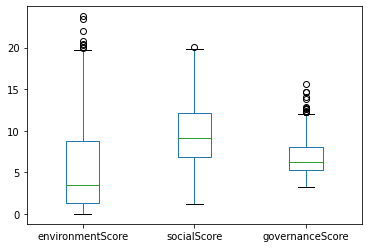

In [89]:
sustain[x_lable_sustain].reset_index(drop = True).plot.box()

In [152]:
list(business_df)

['symbol',
 'zip',
 'sector',
 'fullTimeEmployees',
 'longBusinessSummary',
 'city',
 'phone',
 'state',
 'country',
 'companyOfficers',
 'website',
 'maxAge',
 'address1',
 'industry',
 'ebitdaMargins',
 'profitMargins',
 'grossMargins',
 'operatingCashflow',
 'revenueGrowth',
 'operatingMargins',
 'ebitda',
 'targetLowPrice',
 'recommendationKey',
 'grossProfits',
 'freeCashflow',
 'targetMedianPrice',
 'currentPrice',
 'earningsGrowth',
 'currentRatio',
 'returnOnAssets',
 'numberOfAnalystOpinions',
 'targetMeanPrice',
 'debtToEquity',
 'returnOnEquity',
 'targetHighPrice',
 'totalCash',
 'totalDebt',
 'totalRevenue',
 'totalCashPerShare',
 'financialCurrency',
 'revenuePerShare',
 'quickRatio',
 'recommendationMean',
 'exchange',
 'shortName',
 'longName',
 'exchangeTimezoneName',
 'exchangeTimezoneShortName',
 'isEsgPopulated',
 'gmtOffSetMilliseconds',
 'quoteType',
 'messageBoardId',
 'market',
 'annualHoldingsTurnover',
 'enterpriseToRevenue',
 'beta3Year',
 'enterpriseToEbitda

In [157]:
linear_reg_df = sustain.merge(business_df[["symbol","profitMargins","sector"]], how = "inner", on = "symbol")
linear_reg_df.head()

,symbol,environmentScore,socialScore,governanceScore,profitMargins,sector
0,A,0.87,9.44,6.26,0.19148,Healthcare
1,AAL,11.76,12.65,5.40,-0.13229,Industrials
2,AAP,0.10,9.14,3.33,0.05895,Consumer Cyclical
3,AAPL,0.29,7.99,8.64,0.25882,Technology
4,ABBV,0.65,16.64,10.10,0.13656,Healthcare


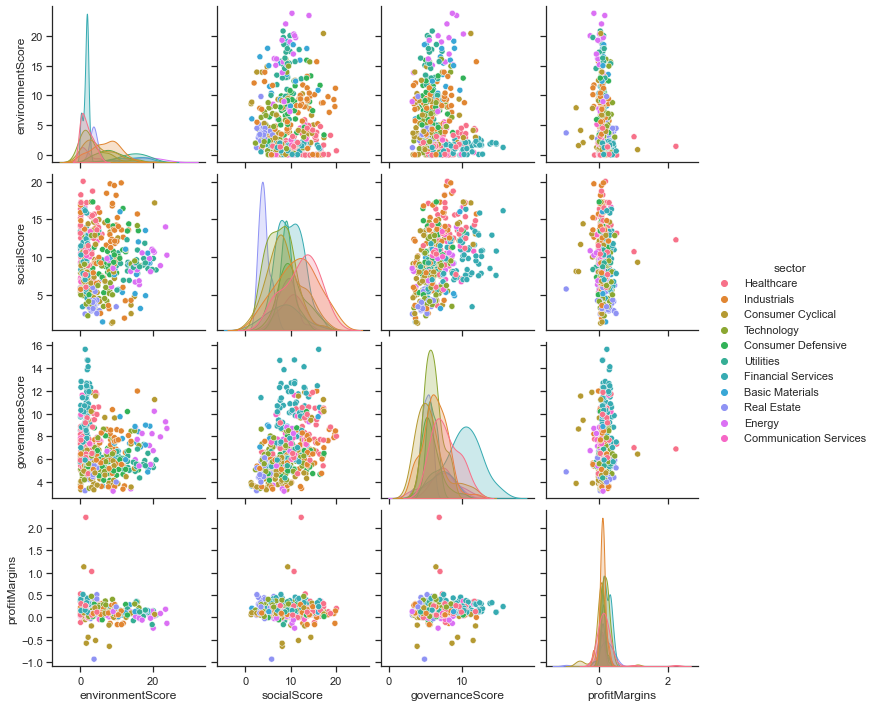

In [159]:
sns.pairplot(linear_reg_df, hue = "sector")

In [163]:
x = linear_reg_df.drop(["symbol","profitMargins","sector"],axis=1)
x = sm.add_constant(x)
y = linear_reg_df["profitMargins"]

In [164]:
ols_mod = sm.OLS(y,x)
ols_res = ols_mod.fit()
ols_resid = ols_res.resid
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          profitMargins   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     6.107
Date:                Tue, 05 Apr 2022   Prob (F-statistic):           0.000446
Time:                        15:16:34   Log-Likelihood:                 128.96
No. Observations:                 448   AIC:                            -249.9
Df Residuals:                     444   BIC:                            -233.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1527      0.032      4.777      0.000       0.090       0.215
environmentScore    -0.0060      0.002     -3.703      0.000      -0.009      -0.003
socialScore         -0.0019      0.002     -0.757      0.449      -0.007       0.003
governanceScore      0.0065      0.004      1.567      0.118      -0.002       0.015
==============================================================================
Omnibus:                      375.812   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35479.381
Skew:                           2.942   Prob(JB):                         0.00
Kurtosis:                      46.198   Cond. No.                         50.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

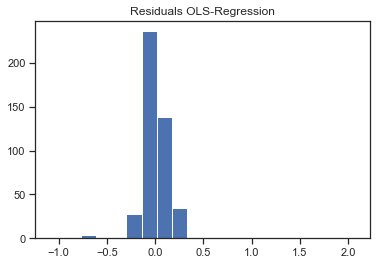

In [165]:
plt.hist(ols_resid, bins= 20)
plt.title("Residuals OLS-Regression");

In [167]:
stat, p = shapiro(ols_resid)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.701, p=0.000


#### Sources of endogeneity
- Omitted variables
- Measurement Error
- Simultaneity in simultaneous equation models
- Autocorrelation in Dynamic Models
 

## Instrumental Variables
##### Durbin, Wu and Hausman test (Lagrange Multiplier test)
Test hypothesis:
$$ H_{0} : E(x_{ji} \epsilon_{i}) = 0, \quad j=k-k_0 + 1,...,k \quad \text{Exogeneity of the regressors} $$ 

##### Sargan test
Test statistic is computed on residuals from the IV regression
Test hypothesis:
$$
H_0: \quad \text{Over-identifying restrictions are valid} \sim \Chi^2_{m-k} \\
\; m: \text{instruments} \; k: \text{endogenous variables} 
$$

## Multiple Instruments - 2SLS

## Panel Data 

##### Pooled OLS

##### Fixed-Effects Model (FE)

##### Random-Effects Model (RE)

In [173]:
pd.Categorical(linear_reg_df["sector"])

['Healthcare', 'Industrials', 'Consumer Cyclical', 'Technology', 'Healthcare', ..., 'Healthcare', 'Industrials', 'Consumer Cyclical', 'Healthcare', 'Healthcare']
Length: 448
Categories (11, object): ['Basic Materials', 'Communication Services', 'Consumer Cyclical', 'Consumer Defensive', ..., 'Industrials', 'Real Estate', 'Technology', 'Utilities']

In [171]:
linear_reg_df["sector"].to_list()

['Healthcare',
 'Industrials',
 'Consumer Cyclical',
 'Technology',
 'Healthcare',
 'Healthcare',
 'Healthcare',
 'Technology',
 'Technology',
 'Technology',
 'Consumer Defensive',
 'Industrials',
 'Technology',
 'Utilities',
 'Utilities',
 'Utilities',
 'Financial Services',
 'Financial Services',
 'Financial Services',
 'Financial Services',
 'Technology',
 'Basic Materials',
 'Financial Services',
 'Industrials',
 'Technology',
 'Industrials',
 'Healthcare',
 'Financial Services',
 'Real Estate',
 'Consumer Cyclical',
 'Technology',
 'Technology',
 'Healthcare',
 'Industrials',
 'Energy',
 'Basic Materials',
 'Technology',
 'Consumer Cyclical',
 'Real Estate',
 'Utilities',
 'Communication Services',
 'Real Estate',
 'Technology',
 'Industrials',
 'Utilities',
 'Financial Services',
 'Consumer Cyclical',
 'Industrials',
 'Financial Services',
 'Healthcare',
 'Consumer Cyclical',
 'Consumer Cyclical',
 'Healthcare',
 'Financial Services',
 'Healthcare',
 'Healthcare',
 'Financial Ser

## Time-Series

White noise:
$$
E(\epsilon_t) = E(\epsilon_t|\epsilon_{t-1},\epsilon_{t-2},...) = 0\\
Var(\epsilon_t) = E(\epsilon_t^2) = \sigma^2 \\
Cov(\epsilon_{t-k}\epsilon_t) = E(\epsilon_{t-k}\epsilon_t) = 0, \quad k \neq t \\
$$
Gaussian white noice:
$$
\text{if} \quad \epsilon_t \sim N(0,\sigma^2)
$$

Autoregressive (AR(p)) process:
$$
y_t = \mu + \alpha_1 y_{t-1} + \alpha_2 y_{t-2} + ... + \alpha_{p} y_{t-p} + \epsilon_t
$$

Moving Average (MA(q)) process
$$
y_t = \psi_0 \epsilon_t + \psi_1 \epsilon_{t-1} + ... + \psi_q \epsilon_{t-q} \\
y_t = \psi(L)\epsilon_t
$$

Autoregressive-Moving-Average ARMA(p,q)
$$
y_t = \mu + \alpha_1 y_{t-1} + \psi_0 \epsilon_t + \psi_1 \epsilon_{t-1}
$$